In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. Needed to remove SettingWithCopyWarning warning when assigning new value to dataframe column
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from shapely.geometry import Point, Polygon
import geopandas as gpd

import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

# from housing_crawler.utils import save_file, get_file, get_grid_polygons_all_cities
from housing_crawler.analysis.ads_table_processing import get_processed_ads_table
from housing_crawler.string_utils import remove_prefix, simplify_address, standardize_characters, capitalize_city_name, german_characters

from config.config import ROOT_DIR
from housing_crawler.params import dict_city_number_wggesucht

# Load ads

In [2]:
ads_feat_df = get_processed_ads_table(update_table=True)
list(ads_feat_df.columns)

===> Loaded ads_OSM.csv locally


/home/carlo/code/chvieira2/housing_crawler/housing_crawler/utils.py:35: DtypeWarning: Columns (27,29,33,34,35,36,38,39,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path)


['id',
 'url',
 'commercial_landlord',
 'title',
 'price_euros',
 'size_sqm',
 'available_rooms',
 'capacity',
 'available_spots_wg',
 'male_flatmates',
 'female_flatmates',
 'diverse_flatmates',
 'published_on',
 'published_at',
 'address',
 'city',
 'crawler',
 'latitude',
 'longitude',
 'available_from',
 'available_to',
 'details_searched',
 'cold_rent_euros',
 'mandatory_costs_euros',
 'extra_costs_euros',
 'deposit',
 'zip_code',
 'energy',
 'wg_possible',
 'building_type',
 'building_floor',
 'furniture',
 'kitchen',
 'shower_type',
 'tv',
 'floor_type',
 'heating',
 'public_transport_distance',
 'internet',
 'parking',
 'home_total_size',
 'smoking',
 'wg_type',
 'age_range',
 'gender_search',
 'schufa_needed',
 'transfer_costs_euros',
 'type_offer_simple',
 'extras_waschmaschine',
 'extras_spuelmaschine',
 'extras_terrasse',
 'extras_balkon',
 'extras_garten',
 'extras_gartenmitbenutzung',
 'extras_keller',
 'extras_aufzug',
 'extras_haustiere',
 'extras_fahrradkeller',
 'extr

In [3]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

In [4]:
# Percentage missing values per column
ads_feat_df.isnull().sum().sort_values(ascending=False)/len(ads_feat_df)*100

energy                     95.102286
transfer_costs_euros       94.677669
tv                         94.273681
extra_costs_euros          92.126526
shower_type                89.908888
                             ...    
day_of_week_publication     0.000000
price_per_sqm               0.000000
days_available              0.000000
rental_length_term          0.000000
id                          0.000000
Length: 102, dtype: float64

# Creating WG, single-room and multi-room dataframes

In [5]:
## Filter type of offer
wg_df = ads_feat_df.query('type_offer_simple == "WG"\
                     & price_euros <= 2000\
                     & price_euros > 100\
                     & size_sqm <= 60\
                     & size_sqm >= 5').reset_index(drop=True)

singleroom_df = ads_feat_df.query('type_offer_simple == "Single-room flat"\
                     & price_euros <= 2500\
                     & price_euros > 100\
                     & size_sqm <= 100\
                     & size_sqm >= 10').reset_index(drop=True)

flathouse_df = ads_feat_df.query('(type_offer_simple == "Apartment")\
                     & price_euros <= 6000\
                     & price_euros > 100\
                     & size_sqm <= 300\
                     & size_sqm >= 25').reset_index(drop=True)

In [6]:
wg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42497 entries, 0 to 42496
Columns: 102 entries, id to comfort_street_motorway
dtypes: float64(72), int64(9), object(21)
memory usage: 33.1+ MB


In [7]:
def standardize(df, features):
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

In [24]:
# define columns to work
features = [
    'comfort_leisure_spots',
    'comfort_warehouse',
    'activities_education',
    'mobility_public_transport_bus',
    'activities_economic',
    'comfort_industrial',
    'activities_goverment',
    'social_life_eating',
    'comfort_comfort_spots',
    'social_life_culture',
    'activities_supermarket',
##     'activities_public_service',
    'social_life_community',
    'comfort_leisure_mass',
    'activities_educational',
    'mobility_street_secondary',
    'mobility_public_transport_rail',
    'activities_retail',
    'social_life_night_life',
    'comfort_green_natural',
    'comfort_railway',
    'mobility_bike_infraestructure',
##     'comfort_green_forests',
    'mobility_street_primary',
    'comfort_lakes',
##     'activities_health_regional',
    'activities_health_local',
    'comfort_green_space',
    'comfort_rivers',
    'activities_post',
    'comfort_green_parks',
    'comfort_street_motorway'
]
target = 'price_per_sqm'
selected_num_features = [
    'days_available',
    'rental_length_term',
    'capacity',
    'male_flatmates',
    'female_flatmates',
    'diverse_flatmates',
    
#     'km_to_centroid',
#     'degrees_to_centroid',
    
    'number_languages',
    'deposit',
    'smoking',
    'building_floor',
    'furniture',
    'kitchen',
    'min_age_flatmates',
    'max_age_flatmates',
] #+ features
selected_cat_features = ['city',
                         'commercial_landlord',
                         
                         'languages_deutsch',
                         'languages_englisch',
#                          'zip_code',
#                          'home_total_size',
#                          'wg_type',
#                          'age_range',
#                          'gender_search',
#                          'energy',
#                          'wg_possible',
#                          'building_type',
#                          'shower_type',
#                          'tv',
#                          'floor_type',
                         'heating',
#                          'public_transport_distance',
#                          'internet',
#                          'parking',
#                          'transfer_costs_euros',
                         'schufa_needed',
#                          'type_offer_simple',
                         'extras_waschmaschine',
                         'extras_spuelmaschine',
                         'extras_terrasse',
                         'extras_balkon',
                         'extras_garten',
                         'extras_gartenmitbenutzung',
                         'extras_keller',
                         'extras_aufzug',
                         'extras_haustiere',
                         'extras_fahrradkeller',
                         'extras_dachboden',
#                          'day_of_week_publication',
                        ]
all_columns = [target] + selected_num_features + selected_cat_features

columns_to_zscore = selected_num_features


# Filter dataframe for modelling
wg_df_zscored = wg_df[all_columns#+['city']
                     ].copy()

wg_df_zscored = wg_df_zscored.dropna(axis=0)
# z-scoring columns
wg_df_zscored = standardize(wg_df_zscored, columns_to_zscore)

# Filter table if needed
df_city = wg_df_zscored#[wg_df_zscored['city'] == 'Leipzig']
df_city.shape

(2297, 32)

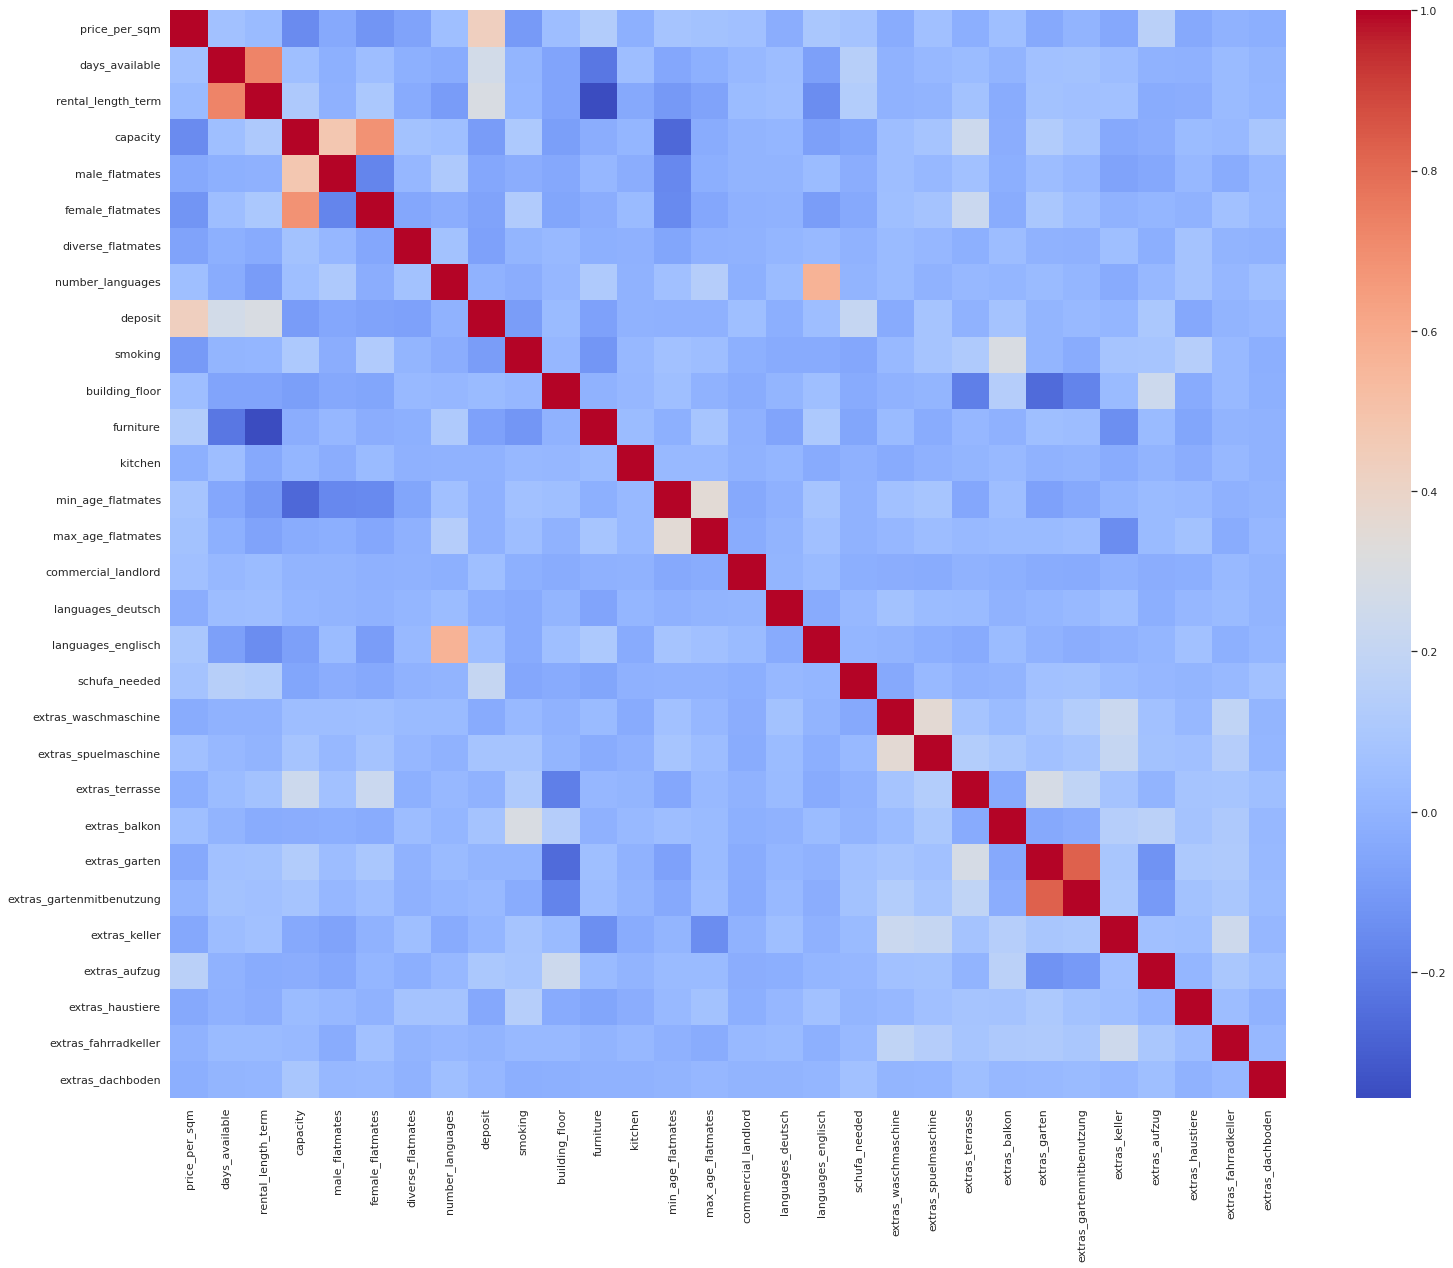

In [25]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 20))

sns.heatmap(df_city.corr(), cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8});

In [26]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()

df["features"] = columns_to_zscore

df["vif_index"] = [vif(df_city[columns_to_zscore].values, i) for i in range(df_city[columns_to_zscore].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)

,features,vif_index
2,capacity,6.52
4,female_flatmates,5.04
3,male_flatmates,3.44
1,rental_length_term,2.48
0,days_available,2.18
12,min_age_flatmates,1.26
10,furniture,1.19
13,max_age_flatmates,1.18
7,deposit,1.14
5,diverse_flatmates,1.09


In [27]:
# OLS model
formula = target + ' ~ ' + ' + '.join(selected_num_features) + ' + ' + ' + '.join(['C('+feat+')-1' for feat in selected_cat_features]) + '-1'

model_city = smf.ols(formula = formula, data=df_city).fit()
model_city.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_per_sqm   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     24.60
Date:                Wed, 24 Aug 2022   Prob (F-statistic):          8.51e-196
Time:                        19:08:36   Log-Likelihood:                -8210.7
No. Observations:                2297   AIC:                         1.654e+04
Df Residuals:                    2238   BIC:                         1.688e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(city)[Aachen]                        25.7427      2.272     11.329      0.000      21.287      30.199
C(city)[Berlin]                        30.4899      1.986     15.352      0.000      26.595      34.385
C(city)[Bonn]                          24.9994      2.340     10.681      0.000      20.410      29.589
C(city)[Bremen]                        26.5932      2.223     11.961      0.000      22.233      30.953
C(city)[Darmstadt]                     26.4582      2.325     11.379      0.000      21.898      31.018
C(city)[Dresden]                       22.3314      2.218     10.069      0.000      17.982      26.680
C(city)[Düsseldorf]                    29.4213      2.570     11.448      0.000      24.382      34.461
C(city)[Frankfurt am Main]             32.3681      2.206     14.674      0.000      28.042      36.694
C(city)[Göttingen]                     23.3698      2.395      9.756      0.000      18.672      28.067
C(city)[Hamburg]                       35.1524      2.081     16.891      0.000      31.071      39.234
C(city)[Hannover]                      25.9581      2.275     11.413      0.000      21.498      30.419
C(city)[Heidelberg]                    27.0232      2.372     11.392      0.000      22.372      31.675
C(city)[Karlsruhe]                     25.1051      2.194     11.444      0.000      20.803      29.407
C(city)[Kiel]                          24.8395      2.677      9.277      0.000      19.589      30.090
C(city)[Köln]                          30.1638      2.196     13.737      0.000      25.858      34.470
C(city)[Leipzig]                       21.0591      2.210      9.529      0.000      16.725      25.393
C(city)[Mainz]                         25.8682      2.385     10.848      0.000      21.192      30.544
C(city)[Mannheim]                      27.2376      2.265     12.023      0.000      22.795      31.680
C(city)[München]                       37.5922      2.088     18.002      0.000      33.497      41.687
C(city)[Münster]                       24.4556      2.366     10.337      0.000      19.816      29.095
C(city)[Nürnberg]                      23.1740      2.277     10.179      0.000      18.710      27.638
C(city)[Regensburg]                    25.3057      2.614      9.680      0.000      20.179      30.432
C(city)[Stuttgart]                     31.4492      2.103     14.952      0.000      27.324      35.574
C(city)[Tübingen]                      29.3698      2.913     10.082      0.000      23.657      35.082
C(city)[Würzburg]                      25.1584      2.558      9.836      0.000      20.143      30.174
C(commercial_landlord)[T.1]             4.7974      2.972      1.614      0.107      -1.030      10.625
C(languages_deutsch)[T.1.0]            -0.5814      1.736     -0.33

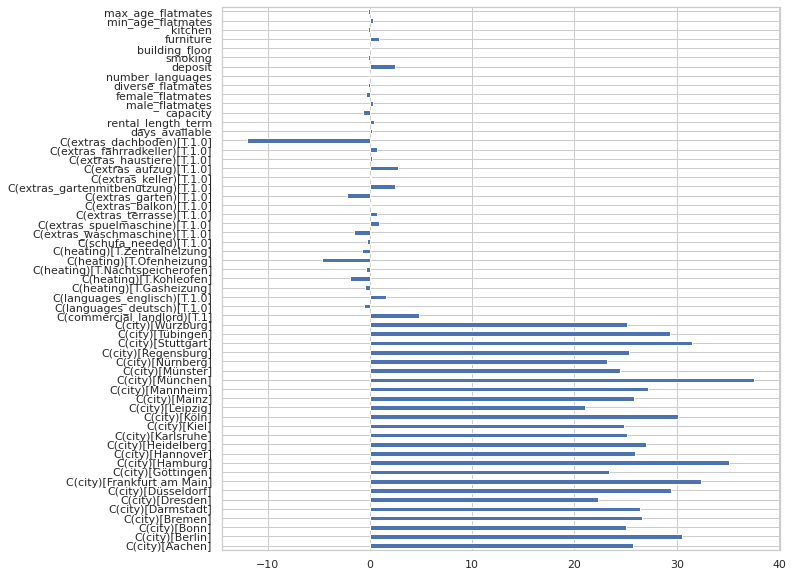

In [28]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

model_city.params[0:].plot(kind='barh');

RMSE: 8.63317992674323
RMSE base model: 11.047272826849973


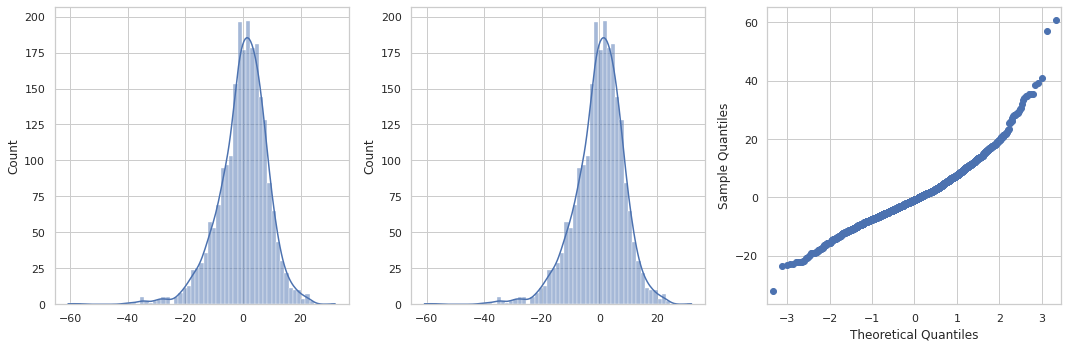

In [29]:
y_pred = model_city.predict(df_city)
y_base = [np.mean(df_city['price_per_sqm'])]*len(y_pred)
y_true = df_city['price_per_sqm']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_city)
residuals = y_pred - y_true
residuals_base = y_pred - y_true
# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model_city.resid, ax=ax3)
plt.tight_layout()
fig.show();

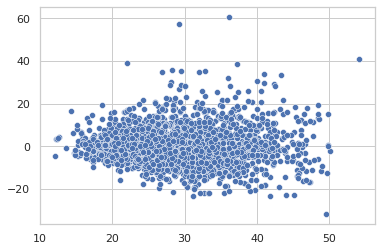

In [30]:
sns.scatterplot(x=model_city.predict(df_city), y=model_city.resid);

                                          p_value       coef
variable                                                    
C(city)[München]                     9.058948e-68  37.592215
C(city)[Hamburg]                     2.443787e-60  35.152371
C(city)[Frankfurt am Main]           1.296313e-46  32.368114
C(city)[Stuttgart]                   2.983154e-48  31.449152
C(city)[Berlin]                      1.194189e-50  30.489886
C(city)[Köln]                        2.739666e-41  30.163781
C(city)[Düsseldorf]                  1.569505e-29  29.421344
C(city)[Tübingen]                    2.072775e-23  29.369778
C(city)[Mannheim]                    2.598763e-32  27.237575
C(city)[Heidelberg]                  2.870427e-29  27.023187
C(city)[Bremen]                      5.237664e-32  26.593168
C(city)[Darmstadt]                   3.329392e-29  26.458207
C(city)[Hannover]                    2.307917e-29  25.958115
C(city)[Mainz]                       9.292684e-27  25.868151
C(city)[Aachen]         

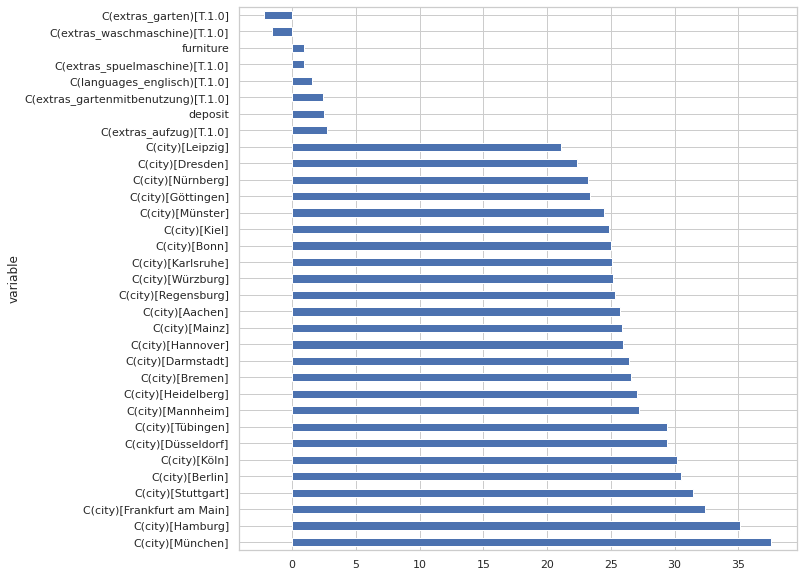

In [31]:
def return_significative_coef(model):
    """
    Returns p_value, lower and upper bound coefficients
    from a statsmodels object.
    """
    # Extract p_values
    p_values = model.pvalues.reset_index()
    p_values.columns = ['variable', 'p_value']

    # Extract coef_int
    coef = model.params.reset_index()
    coef.columns = ['variable', 'coef']
    return p_values.merge(coef,
                          on='variable')\
                   .query("p_value<0.05").sort_values(by='coef',
                                                      ascending=False)

df = return_significative_coef(model_city).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef.plot(kind='barh');